# Face detection and BMI/Age/Sex prediction

The model provides end-to-end capability of detecting faces and predicting the BMI, Age and Gender for each person. 

The architecture of the model is described as below:

![](./img/model_structure.jpg)


## Face detection

Face detection is done by `MTCNN`, which is able to detect multiple faces within an image and draw the bounding box for each faces.  

It serves two purposes for this project:

### 1) preprocess and align the facial features of image.

Prior model training, each image is preprocessed by `MTCNN` to extract faces and crop images to focus on the facial part. The cropped images are saved and used to train the model in later part.

Illustration of face alignment:
![](./img/mtcnn_face_alignment.jpg)

### 2) enable prediction for multiple persons in the same image.

In inference phase, faces will be detected from the input image. For each face, it will go through the same preprocssing and make the predictions.

Illustration of ability to predict for multiple faces:
![](./img/detect_predict_multi_faces.png)

## Multi-task prediction

In vanilla CNN architecture, convolution blocks are followed by the dense layers to make output the prediction. In a naive implementation, we can build 3 models to predict BMI, age and gender individually. However, there is a strong drawback that 3 models are required to be trained and serialized separately, which drastically increases the maintenance efforts.

|   |
|---|
|`[input image] => [VGG16] => [dense layers] => [BMI]`|
|`[input image] => [VGG16] => [dense layers] => [AGE]`|
|`[input image] => [VGG16] => [dense layers] => [SEX]`|

Since we are going to predict `BMI`, `Age`, `Sex` from the same image, we can share the same backbone for the three different prediction heads and hence only one model will be maintained.

|    |
|----|
|`[input image] => [VGG16] => [separate dense layers] x3 => weighted([BMI], [AGE], [SEX])`|

This is the most simplified multi-task learning structure, which assumed independent tasks and hence separate dense layers were used for each head. Other research such as `Deep Relationship Networks`, used `matrix priors` to model the relationship between tasks.

![](https://ruder.io/content/images/2017/05/relationship_networks.png)
_A Deep Relationship Network with shared convolutional and task-specific fully connected layers with matrix priors (Long and Wang, 2015)._
 
## Reference
 * MTCNN: [https://github.com/ipazc/mtcnn](https://github.com/ipazc/mtcnn)
 * VGGFace: [https://github.com/rcmalli/keras-vggface](https://github.com/rcmalli/keras-vggface)

In [1]:
mode = 'train' #'train' or 'predict'
model_type = 'vgg16'
model_tag = 'base'
model_id = '{:s}_{:s}'.format(model_type, model_tag)
model_dir = './saved_model/model_{:s}.h5'.format(model_id)
bs = 8
epochs = 2
freeze_backbone = True # True => transfer learning; False => train from scratch

In [2]:
import pandas as pd
import os
import json
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
from pathlib import Path
from scripts.models import FacePrediction
import glob

allimages = os.listdir('./data/face_aligned/')
train = pd.read_csv('./data/train.csv')
valid = pd.read_csv('./data/valid.csv')

train = train.loc[train['index'].isin(allimages)]
valid = valid.loc[valid['index'].isin(allimages)]
print()

In [3]:
# create metrics, model dirs
Path('./metrics').mkdir(parents = True, exist_ok = True)
Path('./saved_model').mkdir(parents = True, exist_ok = True)

## Data

This is fairly small dataset, which comprises 1530 records and  16 columns.

* sex imbalance: 80% of the data is male
* age is near truncated normal distribution. min Age is 18, average Age is 34.
* race is dominated by Black and White. Asian samples are very limited.
* BMI is normal distrbuted, with mean at 26.

* no obvious correlation found between BMI and Age, Sex.

In [4]:
data = pd.concat([train, valid])
data[['age','race','sex','bmi','index']].head()

age   race   sex        bmi       index
0   54  Black  Male  39.051641  248038.jpg
1   26  Black  Male  29.288731  250464.jpg
2   24  White  Male  42.825039  263711.jpg
3   21  Black  Male  23.028211  270020.jpg
4   29  White  Male  29.529925  277774.jpg

C:\Users\haris\AppData\Local\Temp\ipykernel_15332\2099429914.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.age,  bins = 30, kde=False, color=color, ax = axs[1])
C:\Users\haris\AppData\Local\Temp\ipykernel_15332\2099429914.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.bmi,  

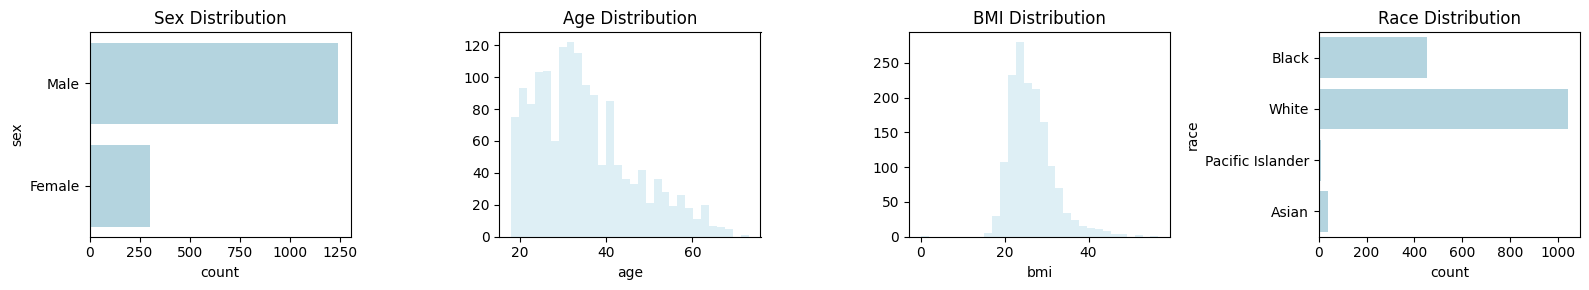

In [5]:
color = 'lightblue'
fig, axs = plt.subplots(1,4)
fig.set_size_inches((16, 3))
sns.countplot(y = data.sex, color = color, ax = axs[0])
axs[0].set_title('Sex Distribution')
sns.distplot(data.age,  bins = 30, kde=False, color=color, ax = axs[1])
axs[1].set_title('Age Distribution')
sns.distplot(data.bmi,  bins = 30, kde=False, color=color, ax = axs[2])
axs[2].set_title('BMI Distribution')
sns.countplot(y = data.race, color = color, ax = axs[3])
axs[3].set_title('Race Distribution')
plt.tight_layout()

In [6]:
def sns_hist(data, x, hue, ax = None, title = 'title', xlabel = None, **kwargs):
    
    xlabel = x.upper() if xlabel == None else xlabel
    
    group = data[hue].unique()
    for g in group:
        sns.distplot(data.loc[data[hue] == g, x], label = g, ax = ax,  **kwargs)
    if ax == None:
        plt.legend()
        plt.title(title)
        plt.xlabel(xlabel)
    else:
        ax.legend()
        ax.set_title(title)
        ax.set_xlabel(xlabel)
    return ax

C:\Users\haris\AppData\Local\Temp\ipykernel_15332\2236071862.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[data[hue] == g, x], label = g, ax = ax,  **kwargs)
C:\Users\haris\AppData\Local\Temp\ipykernel_15332\2236071862.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(data.loc[d

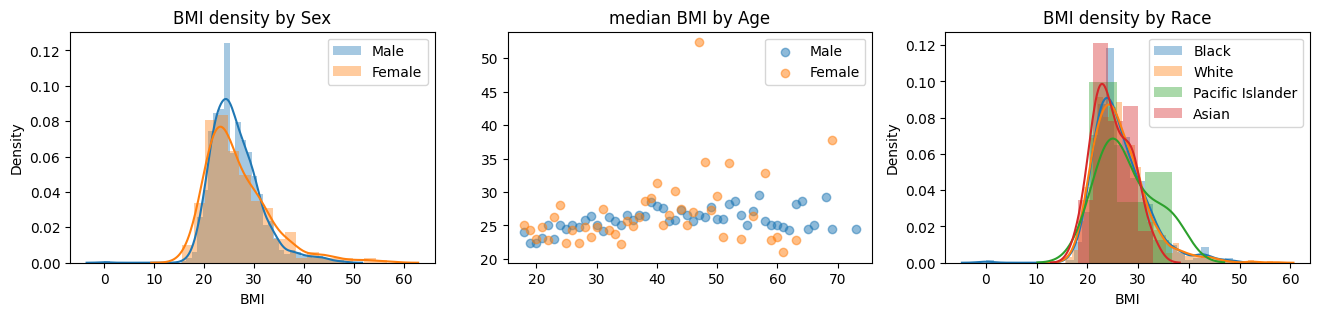

In [7]:
fig, axs = plt.subplots(1,3)
fig.set_size_inches((16, 3))

sns_hist(data, x = 'bmi', hue = 'sex', ax = axs[0], title = 'BMI density by Sex', kde = True)

res = data.groupby(['age','sex'], as_index=False)['bmi'].median()
for i in ['Male','Female']:
    axs[1].scatter(res.loc[res.sex == i,'age'].values, res.loc[res.sex == i,'bmi'].values,label = i, alpha = 0.5)
axs[1].set_title('median BMI by Age')
axs[1].legend()

sns_hist(data, x = 'bmi', hue = 'race', ax = axs[2], title = 'BMI density by Race', kde = True)

plt.show()

## Training

In [8]:
es = EarlyStopping(patience=3)
ckp = ModelCheckpoint(model_dir, save_best_only=True, save_weights_only=True, verbose=1)
tb = TensorBoard('./tb/%s'%(model_id))
callbacks = [es, ckp]

model = FacePrediction(img_dir = './data/face_aligned/', model_type = model_type)
model.define_model(freeze_backbone = freeze_backbone)
model.model.summary()
if mode == 'train':
    model_history = model.train(train, valid, bs = bs, epochs = epochs, callbacks = callbacks)
else:
    model.load_weights(model_dir)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_1 (Conv2D)               (None, 224, 224, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_2 (Conv2D)               (None, 224, 224, 64  36928       ['conv1_1[0][0]']                
                                )                                                           

e:\BMI-from-face-images\scripts\models.py:167: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  self.model.fit_generator(train_gen, len(train_data) // bs, epochs,


Epoch 1/2
154/154 [==============================] - ETA: 0s - loss: 20.0720 - bmi_loss: 21.4779 - age_loss: 28.7024 - sex_loss: 0.1942 - sex_accuracy: 0.9302
Epoch 1: val_loss improved from inf to 12.14154, saving model to ./saved_model\model_vgg16_base.h5
154/154 [==============================] - 504s 3s/step - loss: 20.0720 - bmi_loss: 21.4779 - age_loss: 28.7024 - sex_loss: 0.1942 - sex_accuracy: 0.9302 - val_loss: 12.1415 - val_bmi_loss: 12.6082 - val_age_loss: 20.4426 - val_sex_loss: 0.1074 - val_sex_accuracy: 0.9493
Epoch 2/2
154/154 [==============================] - ETA: 0s - loss: 7.8568 - bmi_loss: 8.0274 - age_loss: 14.2689 - sex_loss: 0.0799 - sex_accuracy: 0.9756
Epoch 2: val_loss improved from 12.14154 to 4.47977, saving model to ./saved_model\model_vgg16_base.h5
154/154 [==============================] - 671s 4s/step - loss: 7.8568 - bmi_loss: 8.0274 - age_loss: 14.2689 - sex_loss: 0.0799 - sex_accuracy: 0.9756 - val_loss: 4.4798 - val_bmi_loss: 4.6875 - val_age_loss: 

## Evaluations

![](./img/tensorboard_results.png)

| Model | BMI (RMSE) | Age (RMSE) | Sex (AUC) |
|-------|------------|------------|-----------|
|vgg16  |4.56|5.66|0.99|
|vgg16_fc6| 4.99 | 6.04 | 0.99 |
|resnet50|5.21 | 7.02 | 0.99|

In [9]:
valid['gender'] = valid.sex.map(lambda i: 1 if i == 'Male' else 0)

In [10]:
metrics = model.evaulate(valid)
metrics['model'] = model_type
with open('./metrics/{:s}.json'.format(model_type), 'w') as f:
    json.dump(metrics, f)

metrics = []
for i in glob.glob('./metrics/*.json'):
    with open(i, 'r') as f:
        res = json.load(f)
    metrics.append(res)
metrics = pd.DataFrame(metrics)
metrics['model'] = metrics['model'].apply(lambda i: '* ' + i if i == model_id else i)
metrics.set_index('model').round(3)

10/10 [==============================] - 82s 8s/step


bmi_mae  bmi_cor  age_mae  sex_auc
model                                          
resnet50       5.140    0.086    7.634    0.995
vgg16          4.761    0.255    7.891    0.997
vgg16_seqMT    6.129    0.274    9.617    0.999

## Predictions

### predict from a single image

In [11]:
model.predict('./data/test/test_aligned/trump.jpg')

1/1 [==============================] - 0s 364ms/step


[array([[35.735355]], dtype=float32),
 array([[74.63988]], dtype=float32),
 array([[0.61212754]], dtype=float32)]

### predict from a directory

1/1 [==============================] - 4s 4s/step


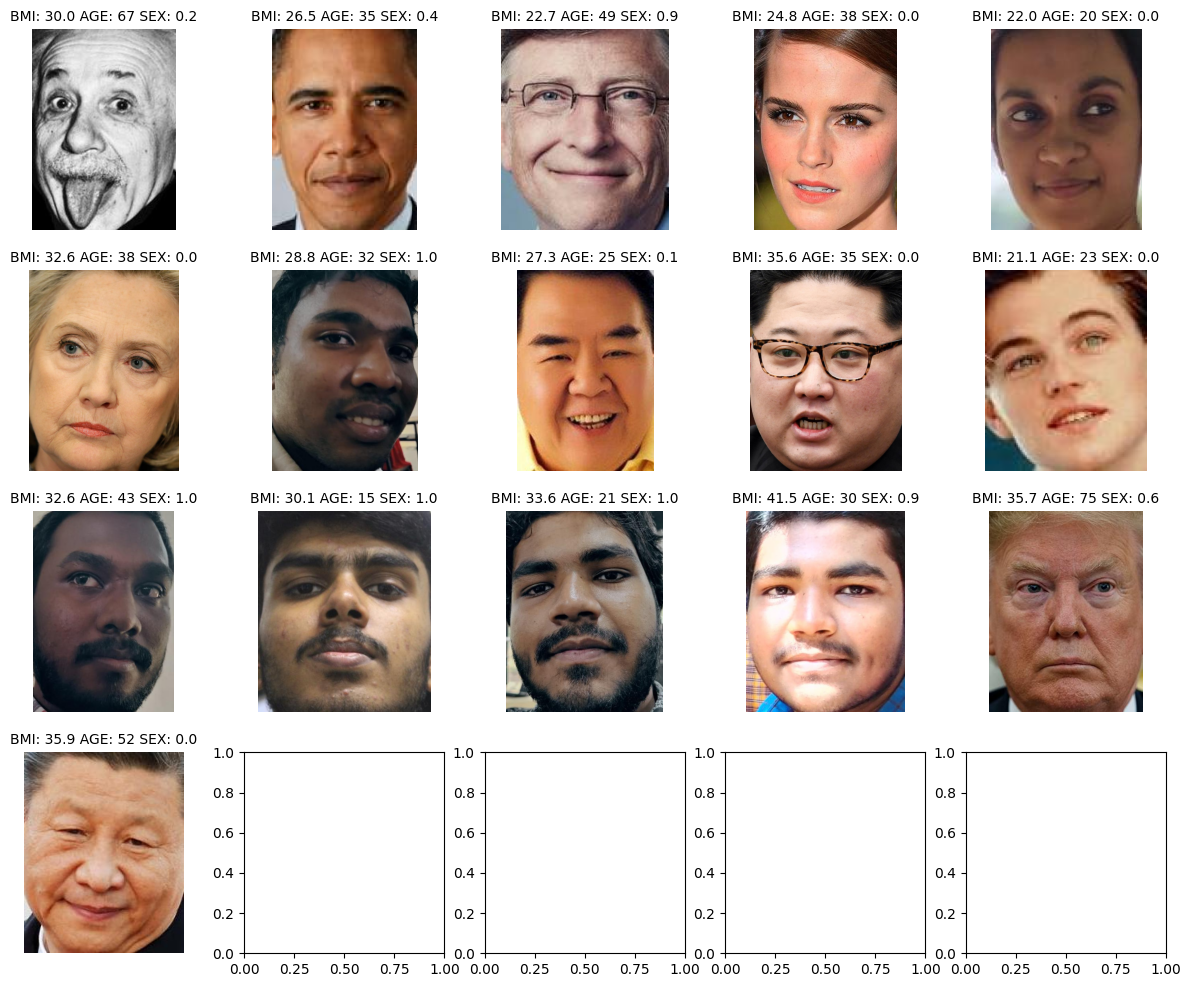

In [12]:
preds = model.predict('./data/test/test_aligned/', show_img = True)

In [13]:
model.predict_df('./data/test/test_aligned')

1/1 [==============================] - 4s 4s/step


img        bmi        age     sex  sex_prob
0   albert-einstein.jpg  29.974670  67.108421    Male  0.238811
1      barack-obama.jpg  26.537722  34.637215    Male  0.449225
2        bill-gates.jpg  22.691919  48.602234    Male  0.882367
3       emma_watson.jpg  24.819204  38.106384  Female  0.000454
4             harsh.jpg  22.011705  20.191038  Female  0.012759
5    hilary_clinton.jpg  32.566475  38.401917  Female  0.000414
6               jai.jpg  28.758549  31.779640    Male  0.999493
7        kent_zheng.jpg  27.315214  24.705008    Male  0.109775
8       Kim Jong-un.jpg  35.626896  34.668419  Female  0.003301
9         leonardo.jpeg  21.142738  22.946192  Female  0.005145
10             logi.jpg  32.618427  43.084251    Male  0.999798
11             nath.jpg  30.088926  15.434071    Male  0.999240
12              pal.jpg  33.556416  21.403936    Male  0.999602
13             pal2.jpg  41.465137  29.895718    Male  0.859019
14            trump.jpg  35.735340  74.639870    Male  0.612128
15               xi.jpg  35.923458  51.860283  Female  0.032087

### predict multiple faces

1/1 [==============================] - 0s 298ms/step


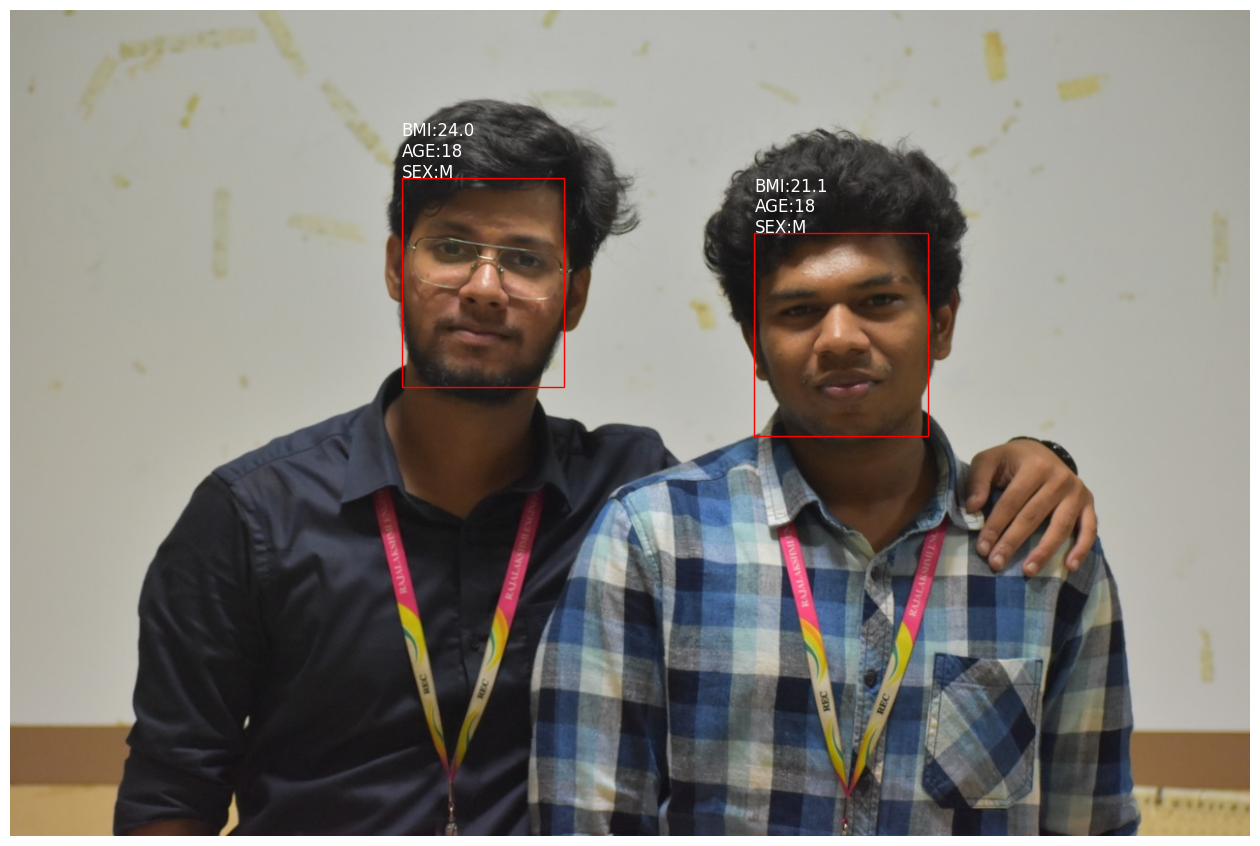

In [14]:
preds = model.predict_faces('./data/test/multi_face/nishanth.jpg', color = 'white')

1/1 [==============================] - 0s 295ms/step


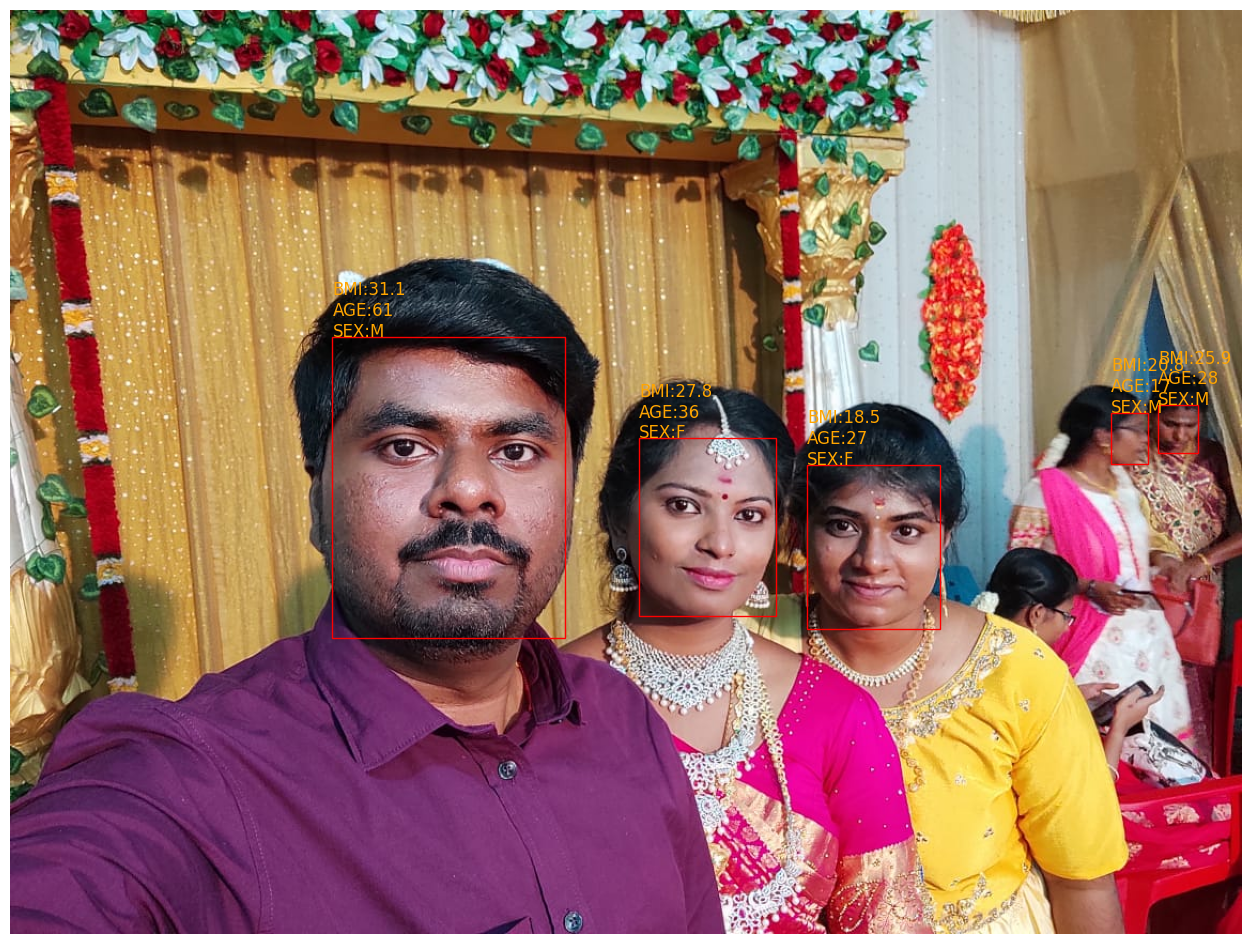

In [16]:
preds = model.predict_faces('./data/test/multi_face/poorvaja.jpg', color = 'orange')